In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 64
learning_rate = 2e-3

# Constants
GAMMA = 0.99
num_steps = 500
max_episodes = 3000
torch.manual_seed(3827673000772462206) 

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=2e-3):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear11 = nn.Linear(hidden_size, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.leaky_relu(self.critic_linear1(state))
        value = F.leaky_relu(self.critic_linear11(value))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [3]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss 

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
    # Plot results
    averaged_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    averaged_rewards = [i for i in averaged_rewards]
    plt.plot(all_rewards,color='steelblue',label='Episodic Reward')
    plt.plot(averaged_rewards,color='darkorange',label='Averaged Episodic Reward')
    plt.ylabel('Total Rewards')
    plt.xlabel('Episodes')

    plt.legend()
    plt.legend.loc='best'
    plt.ylim((-500,-50))
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

    return all_rewards, all_lengths, actor_critic

episode: 0, reward: -500.0, total length: 499, average length: 499.0 
episode: 10, reward: -500.0, total length: 499, average length: 499.0 
episode: 20, reward: -500.0, total length: 499, average length: 499.0 
episode: 30, reward: -500.0, total length: 499, average length: 499.0 
episode: 40, reward: -500.0, total length: 499, average length: 499.0 
episode: 50, reward: -500.0, total length: 499, average length: 499.0 
episode: 60, reward: -452.0, total length: 452, average length: 489.4 
episode: 70, reward: -500.0, total length: 499, average length: 496.8 
episode: 80, reward: -500.0, total length: 499, average length: 449.5 
episode: 90, reward: -408.0, total length: 408, average length: 427.0 
episode: 100, reward: -500.0, total length: 499, average length: 475.0 
episode: 110, reward: -326.0, total length: 326, average length: 472.8 
episode: 120, reward: -415.0, total length: 415, average length: 445.1 
episode: 130, reward: -172.0, total length: 172, average length: 316.4 
epi

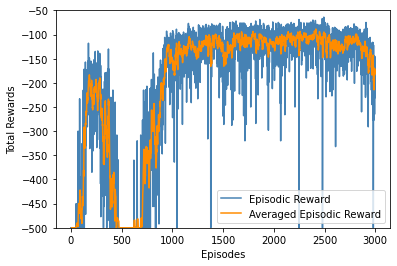

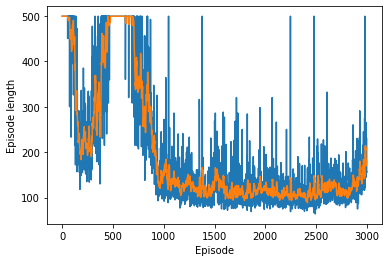

In [4]:
    env = gym.make("Acrobot-v1")
    env.seed(3827673000772462206)
    all_rewards, all_lengths, model = a2c(env)

In [5]:
import numpy as np
np.mean(all_rewards)

-200.19166666666666

In [6]:
np.std(all_rewards)

140.71058570894928

In [7]:
def a2c_test(env, model):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    # actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    actor_critic = model
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []

    for episode in range(1000):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval


        
    
    # Plot results
    averaged_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    averaged_rewards = [i for i in averaged_rewards]
    plt.plot(all_rewards,color='steelblue',label='Episodic Reward')
    plt.plot(averaged_rewards,color='darkorange',label='Averaged Episodic Reward')
    plt.ylabel('Total Rewards')
    plt.xlabel('Episodes')

    plt.legend()
    plt.legend.loc='best'
    plt.ylim((-500,-50))
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()
    
    return all_rewards, all_lengths

episode: 0, reward: -151.0, total length: 151, average length: 151.0 
episode: 10, reward: -198.0, total length: 198, average length: 174.6 
episode: 20, reward: -244.0, total length: 244, average length: 211.1 
episode: 30, reward: -196.0, total length: 196, average length: 183.9 
episode: 40, reward: -150.0, total length: 150, average length: 194.1 
episode: 50, reward: -208.0, total length: 208, average length: 216.2 
episode: 60, reward: -203.0, total length: 203, average length: 176.6 
episode: 70, reward: -294.0, total length: 294, average length: 201.2 
episode: 80, reward: -150.0, total length: 150, average length: 216.5 
episode: 90, reward: -181.0, total length: 181, average length: 226.4 
episode: 100, reward: -255.0, total length: 255, average length: 169.9 
episode: 110, reward: -212.0, total length: 212, average length: 204.9 
episode: 120, reward: -225.0, total length: 225, average length: 176.4 
episode: 130, reward: -131.0, total length: 131, average length: 206.5 
epi

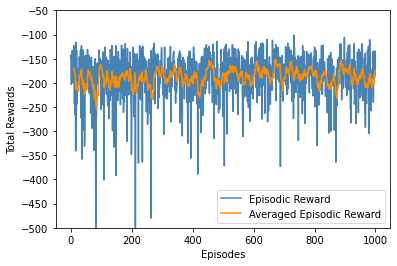

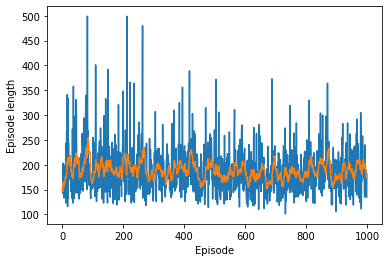

In [8]:
max_episodes = 1000
reward, steps = a2c_test(env, model)

In [9]:
np.mean(reward)

-188.464

In [10]:
np.mean(steps)

188.462

In [11]:
np.std(reward)

49.12201852530085

In [12]:
np.std(steps)

49.1093530399251

In [13]:
import random
seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

Seed was: 3827673000772462206
